In [210]:
import os.path
import requests
from datetime import date, timedelta
import time
import random

from catboost import CatBoostRegressor
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Web Crawling - Downloading the data

In [211]:
start_date = date(2019, 1, 1)
end_date = date(2021, 6, 18)
delta = timedelta(days=1)
while start_date <= end_date:
    print(start_date.strftime("%d-%m-%Y"))
    start_date += delta

    url = 'https://midrug.safenet.co.il/ajax_info.asp?param=81&ShowTable=1&TheDate=' + str(start_date.strftime("%d-%m-%Y"))
    print(url)

    myfile = requests.get(url)
    open('./rating_info' + str(start_date.strftime("%d-%m-%Y")) + '.html', 'wb').write(myfile.content)
    myfile.close()
     sec_sleep = random.randint(0, 25)
    time.sleep(sec_sleep)

01-01-2019
https://midrug.safenet.co.il/ajax_info.asp?param=81&ShowTable=1&TheDate=02-01-2019
02-01-2019
https://midrug.safenet.co.il/ajax_info.asp?param=81&ShowTable=1&TheDate=03-01-2019
03-01-2019
https://midrug.safenet.co.il/ajax_info.asp?param=81&ShowTable=1&TheDate=04-01-2019
04-01-2019
https://midrug.safenet.co.il/ajax_info.asp?param=81&ShowTable=1&TheDate=05-01-2019
05-01-2019
https://midrug.safenet.co.il/ajax_info.asp?param=81&ShowTable=1&TheDate=06-01-2019
06-01-2019
https://midrug.safenet.co.il/ajax_info.asp?param=81&ShowTable=1&TheDate=07-01-2019
07-01-2019
https://midrug.safenet.co.il/ajax_info.asp?param=81&ShowTable=1&TheDate=08-01-2019
08-01-2019
https://midrug.safenet.co.il/ajax_info.asp?param=81&ShowTable=1&TheDate=09-01-2019
09-01-2019
https://midrug.safenet.co.il/ajax_info.asp?param=81&ShowTable=1&TheDate=10-01-2019
10-01-2019
https://midrug.safenet.co.il/ajax_info.asp?param=81&ShowTable=1&TheDate=11-01-2019
11-01-2019
https://midrug.safenet.co.il/ajax_info.asp?param=

# Structuring the data

In [212]:
#make a datafrime from the html files
PATH = "C:\\Users\\Noa\\Documents\\rating_info"
file_list = os.listdir(PATH)
df_all = ""
html_list = []
for file in file_list:
    if os.stat(f"{PATH}\\{file}").st_size != 0:
        html_file = (pd.read_html(f"{PATH}\\{file}", encoding="iso-8859-8")[0])
        html_list.append(html_file)
df_all = pd.concat(html_list)
#df_all.to_csv("test", encoding="utf-8-sig")

In [213]:
df_all = df_all.rename(
    columns={
        'תאריך': 'date',
        'שעת השידורהמקורית': 'time',
        'ערוץ/משדר':'channel',
        'שם התוכנית':'name',
        'דירוג':'score',
        'אלפיפרטים':'views',
        'שיעורי צפייה(%)':'rating',
        'משךבדקות':'duration'
    }
)

In [214]:
df_all

,score,name,channel,time,date,duration,rating,views
0,1,האח הגדול 2020,רשת 13,21:12,01/01/2020,152.0,23.1,412
1,2,האח הגדול 2020,רשת 13,21:12,01/01/2020,152.0,20.1,432
2,3,הצינור,רשת 13,23:43,01/01/2020,22.0,16.2,288
3,4,חדשות 12,קשת 12,19:56,01/01/2020,88.0,15.9,284
4,5,חדשות 12,קשת 12,19:56,01/01/2020,88.0,14.0,301
...,...,...,...,...,...,...,...,...
15,16,חדשות 12,קשת 12,19:55,31/12/2020,98.0,8.6,437
16,17,חדשות 13,רשת 13,19:55,31/12/2020,90.0,8.6,184
17,18,האח הגדול 2021,רשת 13,21:25,31/12/2020,80.0,7.7,388
18,19,היום שהיה עם טל ברמן,רשת 13,23:19,31/12/2020,35.0,7.6,136


# EDA

<AxesSubplot:ylabel='channel'>

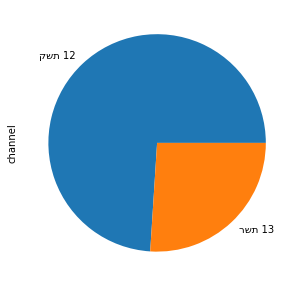

In [215]:
df_all.groupby('channel')['channel'].count().plot.pie(y='channel', figsize=(5, 5))

In [216]:
df_all.groupby('channel')['channel'].count()

channel
קשת 12    8050
רשת 13    2830
Name: channel, dtype: int64

<AxesSubplot:ylabel='Frequency'>

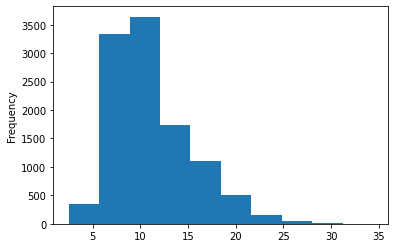

In [217]:
df_all['rating'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

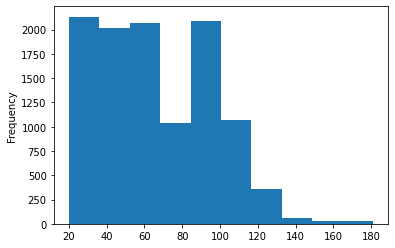

In [218]:
df_all['duration'].plot.hist()

# Feature Engineering

In [219]:
#split the date to day month and year
df_all[["day","month","year"]]=df_all["date"].str.split("/", expand = True)
df_all[["hour","minute"]]=df_all["time"].str.split(":", expand = True)

In [220]:
# add day of week
#Monday=0, Sunday=6.
df_all["date"] = pd.to_datetime(df_all["date"])
df_all['day_of_week'] = df_all['date'].dt.dayofweek
df_all

,score,name,channel,time,date,duration,rating,views,day,month,year,hour,minute,day_of_week
0,1,האח הגדול 2020,רשת 13,21:12,2020-01-01,152.0,23.1,412,01,01,2020,21,12,2
1,2,האח הגדול 2020,רשת 13,21:12,2020-01-01,152.0,20.1,432,01,01,2020,21,12,2
2,3,הצינור,רשת 13,23:43,2020-01-01,22.0,16.2,288,01,01,2020,23,43,2
3,4,חדשות 12,קשת 12,19:56,2020-01-01,88.0,15.9,284,01,01,2020,19,56,2
4,5,חדשות 12,קשת 12,19:56,2020-01-01,88.0,14.0,301,01,01,2020,19,56,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,16,חדשות 12,קשת 12,19:55,2020-12-31,98.0,8.6,437,31,12,2020,19,55,3
16,17,חדשות 13,רשת 13,19:55,2020-12-31,90.0,8.6,184,31,12,2020,19,55,3
17,18,האח הגדול 2021,רשת 13,21:25,2020-12-31,80.0,7.7,388,31,12,2020,21,25,3
18,19,היום שהיה עם טל ברמן,רשת 13,23:19,2020-12-31,35.0,7.6,136,31,12,2020,23,19,3


In [221]:
#split and delete the datafrime columns
selected_columns = df_all[["date","name"]]
new_df = selected_columns.copy()
new_df
df_rating = df_all[["rating"]]
df_all = df_all.drop(columns=["rating","date","time","views"])
df_all

,score,name,channel,duration,day,month,year,hour,minute,day_of_week
0,1,האח הגדול 2020,רשת 13,152.0,01,01,2020,21,12,2
1,2,האח הגדול 2020,רשת 13,152.0,01,01,2020,21,12,2
2,3,הצינור,רשת 13,22.0,01,01,2020,23,43,2
3,4,חדשות 12,קשת 12,88.0,01,01,2020,19,56,2
4,5,חדשות 12,קשת 12,88.0,01,01,2020,19,56,2
...,...,...,...,...,...,...,...,...,...,...
15,16,חדשות 12,קשת 12,98.0,31,12,2020,19,55,3
16,17,חדשות 13,רשת 13,90.0,31,12,2020,19,55,3
17,18,האח הגדול 2021,רשת 13,80.0,31,12,2020,21,25,3
18,19,היום שהיה עם טל ברמן,רשת 13,35.0,31,12,2020,23,19,3


In [222]:
def convet_num_to_int(col,df):
    df[col] = df[col].astype(int)
    return df

def convert_string_to_int(col,df):
    df[col] = df[col].astype('category')
    df[col] = df[col].cat.codes
    return df
        
for col in ["day", "month","year","hour","minute"]:
    df_all = convet_num_to_int(col,df_all)

for col in ["channel","name"]:
    df_all = convert_string_to_int(col,df_all)
    
df_all.dtypes

score            int64
name             int16
channel           int8
duration       float64
day              int32
month            int32
year             int32
hour             int32
minute           int32
day_of_week      int64
dtype: object

In [223]:
df_all

,score,name,channel,duration,day,month,year,hour,minute,day_of_week
0,1,70,1,152.0,1,1,2020,21,12,2
1,2,70,1,152.0,1,1,2020,21,12,2
2,3,141,1,22.0,1,1,2020,23,43,2
3,4,164,0,88.0,1,1,2020,19,56,2
4,5,164,0,88.0,1,1,2020,19,56,2
...,...,...,...,...,...,...,...,...,...,...
15,16,164,0,98.0,31,12,2020,19,55,3
16,17,183,1,90.0,31,12,2020,19,55,3
17,18,74,1,80.0,31,12,2020,21,25,3
18,19,83,1,35.0,31,12,2020,23,19,3


# Splitting the data

In [224]:
X_train, X_test, y_train, y_test = train_test_split(df_all, df_rating, test_size=0.33, random_state=42)

# Training A Regression Model

In [225]:
# Initialize CatBoostRegressor
model = CatBoostRegressor(
    iterations=1500,
    learning_rate=0.2,
    depth=3
)

# Fit model
model.fit(X_train, y_train)

0:	learn: 3.5957549	total: 2.3ms	remaining: 3.45s
1:	learn: 3.2566252	total: 4.69ms	remaining: 3.51s
2:	learn: 2.9938277	total: 6.64ms	remaining: 3.31s
3:	learn: 2.8056903	total: 8.3ms	remaining: 3.11s
4:	learn: 2.6568960	total: 9.92ms	remaining: 2.96s
5:	learn: 2.5390530	total: 11.6ms	remaining: 2.89s
6:	learn: 2.4467455	total: 13.5ms	remaining: 2.87s
7:	learn: 2.3888177	total: 15.2ms	remaining: 2.83s
8:	learn: 2.3317051	total: 17.7ms	remaining: 2.93s
9:	learn: 2.2783082	total: 19.4ms	remaining: 2.89s
10:	learn: 2.2410608	total: 21ms	remaining: 2.84s
11:	learn: 2.2176943	total: 22.7ms	remaining: 2.81s
12:	learn: 2.1919425	total: 24.4ms	remaining: 2.79s
13:	learn: 2.1687202	total: 26.1ms	remaining: 2.77s
14:	learn: 2.1349234	total: 27.7ms	remaining: 2.74s
15:	learn: 2.1181805	total: 29.4ms	remaining: 2.72s
16:	learn: 2.0472733	total: 31.2ms	remaining: 2.72s
17:	learn: 2.0331023	total: 33.3ms	remaining: 2.75s
18:	learn: 1.9860769	total: 35.3ms	remaining: 2.75s
19:	learn: 1.9647993	total

# Predict on test dataset

In [228]:
# Get predictions
preds = model.predict(X_test)
result = pd.DataFrame(preds, columns=['predict'])

# Model Evaluation

In [229]:
y_test = y_test.reset_index(drop = True)


In [230]:
mse = mean_squared_error(y_test.rating, result.predict)
mse

1.2655631397140876

# Scatter Plot

In [231]:
actual_vs_predict = result.merge(y_test, left_index=True, right_index=True)
actual_vs_predict

,predict,rating
0,11.061502,11.7
1,10.585347,10.2
2,13.180146,12.1
3,14.316700,14.3
4,6.735082,7.3
...,...,...
3586,8.355282,7.6
3587,8.670020,7.7
3588,10.736088,11.6
3589,8.960609,8.6


<AxesSubplot:xlabel='rating', ylabel='predict'>

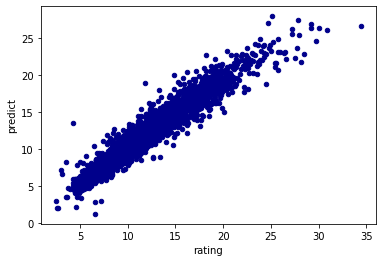

In [206]:
actual_vs_predict.plot.scatter(x='rating', y='predict',c='DarkBlue')